In [6]:
!wget https://www.timeseriesclassification.com/Downloads/MotorImagery.zip
!unzip MotorImagery.zip &> /dev/null
!rm -rf *Dimension*

--2023-04-21 19:53:12--  https://www.timeseriesclassification.com/Downloads/MotorImagery.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124733802 (119M) [application/zip]
Saving to: ‘MotorImagery.zip’

MotorImagery.zip    100%[===================>] 118.96M  56.3MB/s    in 2.1s    

2023-04-21 19:53:14 (56.3 MB/s) - ‘MotorImagery.zip’ saved [124733802/124733802]



In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Define constants
TRAIN_FILES = ['MotorImageryDimension{}_TRAIN.arff'.format(i) for i in range(1, 65)]
TEST_FILES = ['MotorImageryDimension{}_TEST.arff'.format(i) for i in range(1, 65)]
N_DIMENSIONS = 64
SEQ_LEN = 3000
N_CLASSES = 2

# Load and preprocess data
def load_arff_data(filepath):

    data = arff.loadarff(filepath)

    data_size = len(data[0])
    dimensions = len(data[0][0][0])
    time_points = len(data[0][0][0][0])
    TRAIN_X = np.zeros((data_size, time_points, dimensions), dtype=np.float32)
    TRAIN_Y = np.zeros((data_size), dtype=str)
    for i in range(data_size):
        X = [list(data[0][i][0][k]) for k in range(len(data[0][i][0]))]
        X = np.array(X)
        y = str(data[0][i][1], 'UTF-8')
        TRAIN_X[i, :, :] = X.T
        TRAIN_Y[i] = y

    return TRAIN_X, TRAIN_Y


In [8]:
X_train, y_train = load_arff_data("/content" + "/MotorImagery_TRAIN.arff")
X_test, y_test = load_arff_data("/content" + "/MotorImagery_TEST.arff")

In [9]:
# f == 1, t == 0
print(np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test))

(278, 3000, 64) (278,) (100, 3000, 64) (100,)


In [10]:
y_train = np.where(y_train == "f", 1, 0)
y_test = np.where(y_test == "f", 1, 0)

In [42]:
X_train_ = np.copy(X_train)
y_train_ = np.copy(y_train)
X_test_ = np.copy(X_test)
y_test_ = np.copy(y_test)

In [46]:
sample_rate = 1000
ch_names = [str(i) for i in range(64)]
channel_names = ch_names
nchannels = len(ch_names)
cl_lab = ['tongue', 'finger']
(cl1, cl2) = cl_lab
event_codes = [0, 1]
EEG = np.concatenate(X_train_.reshape(278, 64, 3000), axis=-1)
nchannels, nsamples = EEG.shape
event_onsets = np.arange(0, 834000, 3000)
EEG.shape

(64, 834000)

In [47]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sample_rate), int(3.0*sample_rate))

# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    # Extract the onsets for the class
    print(code)
    cl_onsets = event_onsets[y_train_ == code]
    print(cl_onsets)
    
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

  
# Some information about the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

0
[  3000  12000  15000  18000  24000  36000  42000  48000  51000  57000
  66000  75000  78000  81000  96000 102000 108000 111000 126000 132000
 135000 144000 147000 150000 162000 168000 174000 183000 186000 195000
 198000 207000 216000 219000 234000 237000 243000 246000 249000 255000
 258000 264000 267000 270000 276000 282000 285000 288000 291000 306000
 315000 318000 327000 330000 333000 351000 354000 357000 360000 369000
 375000 384000 387000 393000 399000 402000 408000 411000 417000 420000
 423000 426000 429000 432000 441000 456000 459000 462000 471000 474000
 477000 483000 486000 489000 492000 495000 501000 507000 510000 513000
 519000 525000 528000 549000 555000 558000 564000 567000 570000 585000
 594000 597000 612000 630000 636000 642000 645000 651000 654000 657000
 666000 669000 672000 675000 678000 681000 690000 693000 696000 702000
 714000 717000 720000 729000 732000 741000 747000 753000 756000 762000
 765000 768000 771000 777000 783000 789000 795000 822000 828000]
1
[     0 

In [48]:
from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal
    
    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.  
    freqs : list of floats
        Yhe frequencies for which the PSD was computed (useful for plotting later)
    '''
    
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 1251, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs


In [49]:
# Apply the function
psd_r, freqs = psd(trials[cl1])
psd_f, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}

In [50]:
import matplotlib.pyplot as plt

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd().
    
    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd() 
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    if len(chan_ind) > 5:
        plt.figure(figsize=(12,60))
    else:
        plt.figure(figsize=(12, 5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()


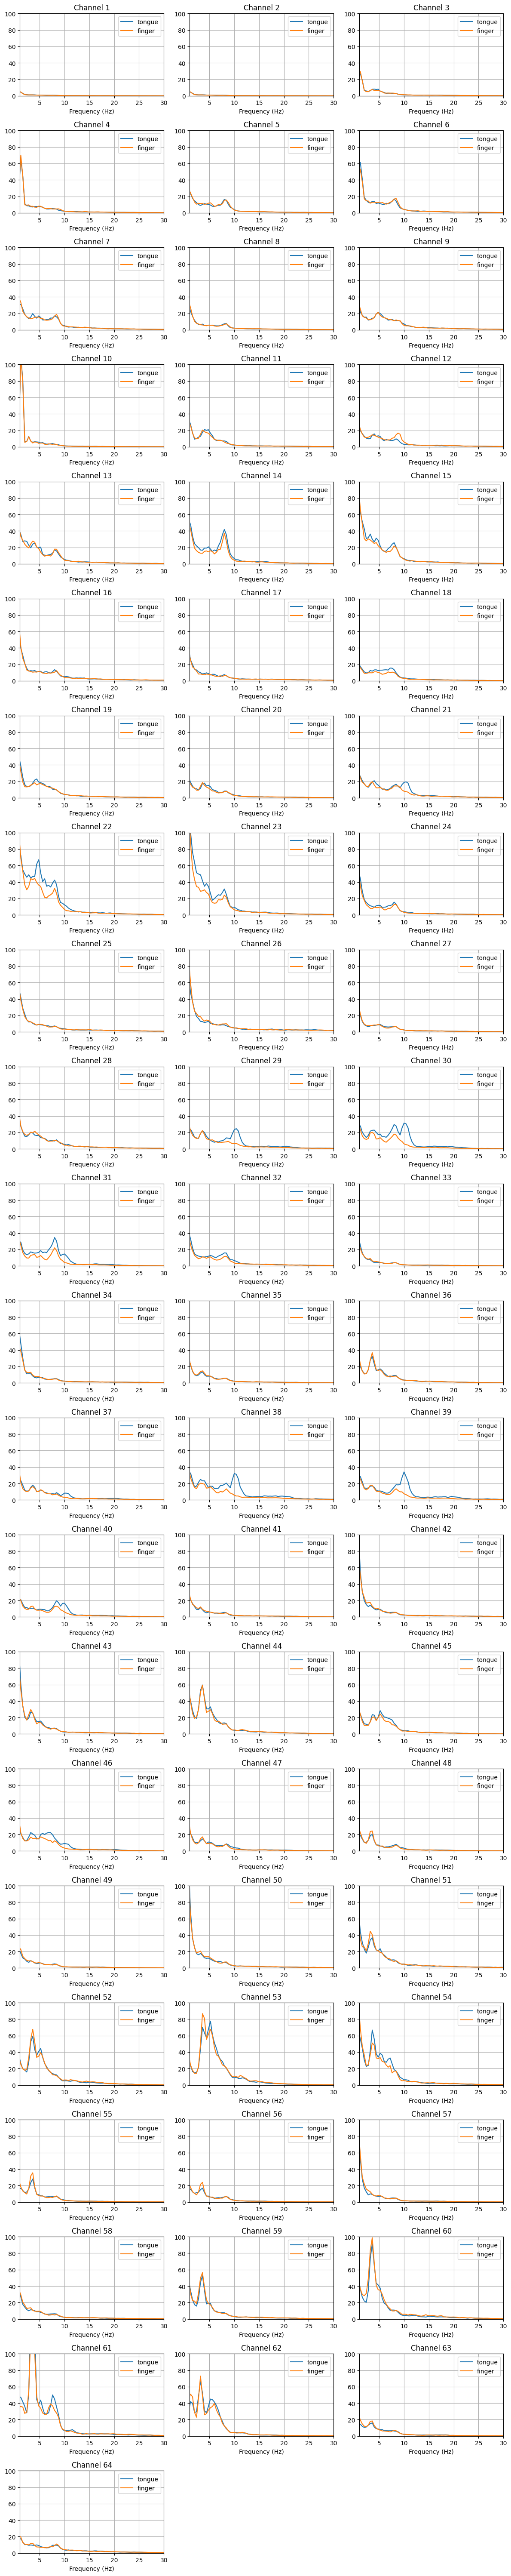

In [51]:
plot_psd(
    trials_PSD,
    freqs,
    range(64),
    maxy=100
)

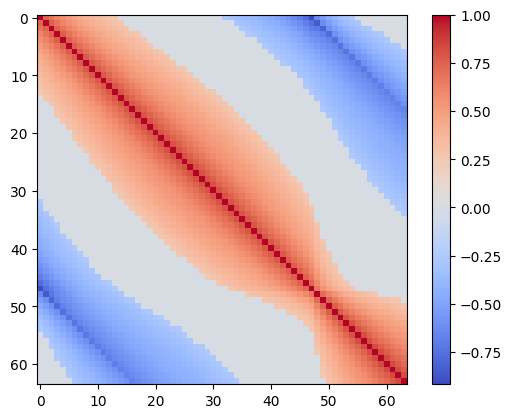

In [ ]:
nimport numpy as np
import matplotlib.pyplot as plt

corr_matrix = np.where(np.abs(np.corrcoef(X_train_.reshape(278*3000, 64), rowvar=False)) > 0.25, np.corrcoef(X_train_.reshape(278*3000, 64), rowvar=False), 0)
# corr_matrix = np.corrcoef(X_train_[1, :, :].reshape(3000, 64), rowvar=False)
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()
plt.show()


In [ ]:
def reshape(X):
  return np.reshape(X, (X.shape[0], -1))

In [ ]:
X_train_.shape

(278, 3000, 64)

In [ ]:
sel_features = np.array([29,30,31,38,39,40,46])
X_train = reshape(X_train_[:, -1000:, sel_features])
y_train = reshape(y_train)
y_train = y_train.ravel()
X_test = reshape(X_test_[:, -1000:, sel_features])
y_test = reshape(y_test)
y_test = y_test.ravel()

In [ ]:
print(np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test))

(278, 21000) (278,) (100, 21000) (100,)


In [ ]:
# only random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# create and train a random forest classifier
n_estimators = 100  # number of trees in the forest
max_depth = 10  # maximum depth of each tree
rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
rfc.fit(X_train, y_train)

# predict on test set
y_pred = rfc.predict(X_test)

# evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.59


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

n_estimators = 100  # number of trees in the forest
max_depth = 10  # maximum depth of each tree

# Train different models on the training set
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
svm_model = SVC()
lgbm_model = LGBMClassifier(n_estimators=100)
dt_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()

rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Use each model to make predictions on the validation set
rf_preds = rf_model.predict(X_test)
svm_preds = svm_model.predict(X_test)
dt_preds = dt_model.predict(X_test)
lgbm_preds = lgbm_model.predict(X_test)

# Concatenate the predictions from each model to create a new feature matrix
X_val_new = np.column_stack((rf_preds, svm_preds, dt_preds, lgbm_preds))

# Train a meta-model on the new feature matrix
meta_model = LogisticRegression()
meta_model.fit(X_val_new, y_test)

# Use the trained meta-model to make predictions on the test set
rf_test_preds = rf_model.predict(X_test)
svm_test_preds = svm_model.predict(X_test)
dt_test_preds = dt_model.predict(X_test)
lgbm_test_preds = lgbm_model.predict(X_test)

X_test_new = np.column_stack((rf_test_preds, svm_test_preds, dt_test_preds, lgbm_test_preds))
ensemble_preds = meta_model.predict(X_test_new)

# Evaluate the accuracy of the ensemble model
ensemble_acc = accuracy_score(y_test, ensemble_preds)

print(f"Ensemble accuracy: {ensemble_acc:.2f}")


Ensemble accuracy: 0.69


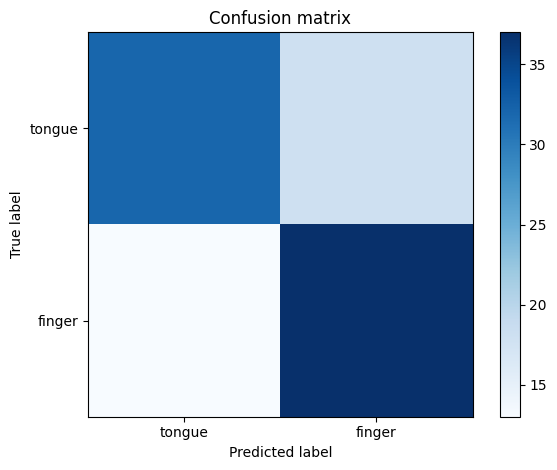

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, f1_score, recall_score, precision_score, accuracy_score

# Make predictions on test data
# y_pred = np.round(model.predict(test_data)).astype(int)
y_pred_prob = meta_model.predict(X_test_new)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['tongue', 'finger'])
plt.yticks(tick_marks, ['tongue', 'finger'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


In [ ]:
cm

array([[32, 18],
       [13, 37]])

In [ ]:
# Compute the evaluation metrics
# loss, accuracy = model.evaluate(test_data, test_labels)
accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'MCC: {mcc:.3f}')
print(f'F1 score: {f1:.3f}')
print(f'Recall: {recall:.3f}')
print(f'Precision: {precision:.3f}')

Accuracy: 0.690
MCC: 0.382
F1 score: 0.705
Recall: 0.740
Precision: 0.673


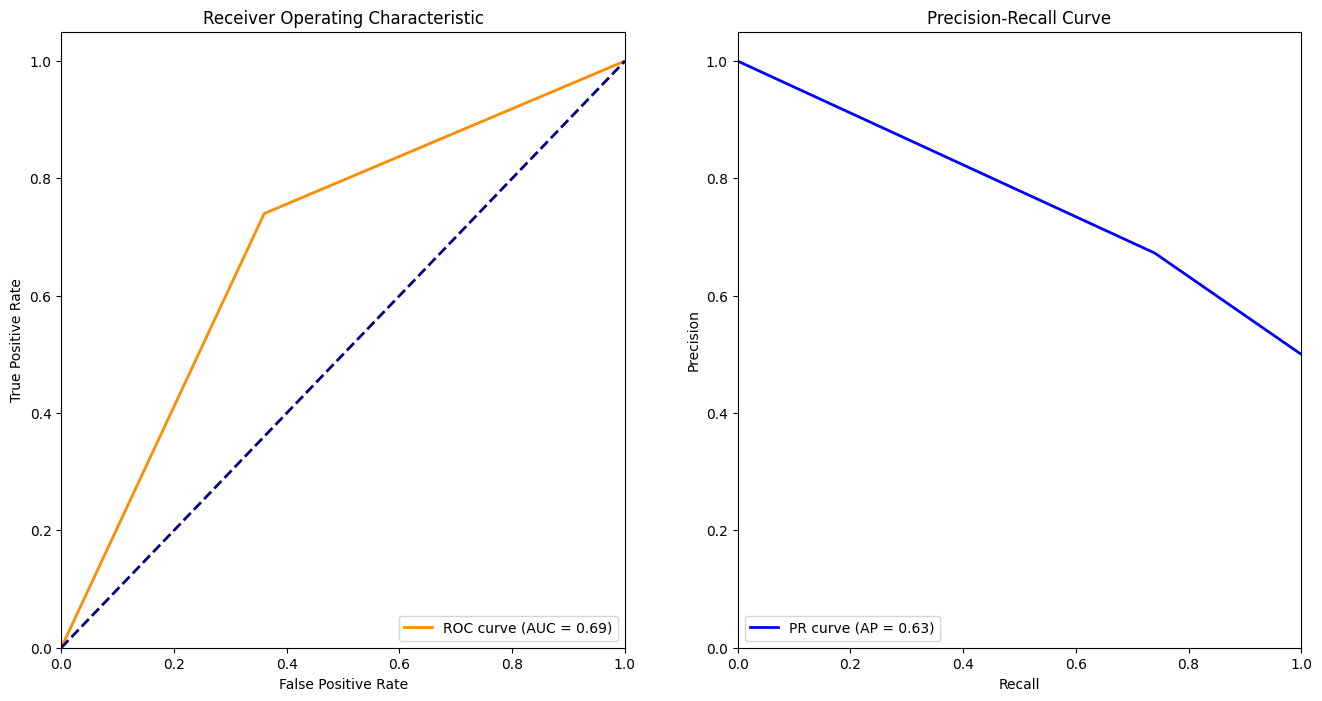

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Predict the test examples and compute the predicted probabilities
y_pred_prob = meta_model.predict(X_test_new)

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# calculate PR curve and average precision
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# plot ROC curve and AUC
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# plot PR curve and average precision
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (AP = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.show()

# # Plot the ROC curve
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic (ROC) curve')
# plt.legend(loc="lower right")
# plt.show()
